<a href="https://colab.research.google.com/github/SPlearning27/Cohort-18-Projects/blob/main/Capstone-Project/%20ver4_SAME_training_testing_Model_EVregistration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of EV Charging station installed in ABQ, NM

## Project Problems




What is the trend of the number of EVs in the next six months?

## Direction for data processing

To predict the number of EV cars in the next 6 months of 2025 using a machine learning model, we'll need to approach this as a time series forecasting problem


## Expected Outcomes

- We can use the data outcomes from this data processing to taking into consideration the marker growth-driving factors:

To answer...

  (1) what is the predictive number of EV cars per zip code?

  (2) Where (zip code) can we locate new EV charging stations based on the business factors?
  

## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow.keras as keras
import tensorflow as tf
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import datasets


In [ ]:
!pip install --upgrade numpy pandas scikit-learn statsmodels
!pip install --upgrade pmdarima

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


## Data Collection/Sources
[State EV Registration](https://www.atlasevhub.com/market-data/state-ev-registration-data/#data)


In [ ]:
url = "https://a068e7e0.delivery.rocketcdn.me/public/dmv/NM_EV_Registrations_07.csv"
url

'https://a068e7e0.delivery.rocketcdn.me/public/dmv/NM_EV_Registrations_07.csv'

### IDA

In [ ]:
!curl -s -I {url} | grep -e HTTP -e Content-

HTTP/2 200 


In [ ]:
!curl -s {url} | head -3

State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
"NM","87106","9/1/2023","TESLA","MODEL 3","2023","BEV","1","Light-Duty (Class 1-2A)",1,7,"DMV Snapshot (5/1/2024)",False
"NM","88012","9/1/2023","TESLA","MODEL 3","2023","BEV","1","Light-Duty (Class 1-2A)",1,1,"DMV Snapshot (10/2/2023)",False


In [ ]:
!curl -s {url} | head -1 | tr , '\n' | cat -n

     1	State
     2	ZIP Code
     3	Registration Date
     4	Vehicle Make
     5	Vehicle Model
     6	Vehicle Model Year
     7	Drivetrain Type
     8	Vehicle GVWR Class
     9	Vehicle GVWR Category
    10	Vehicle Count
    11	DMV Snapshot ID
    12	DMV Snapshot (Date)
    13	Latest DMV Snapshot Flag


- Note: Aggregations of these data should be weighted by the values of vehicle count.


In [ ]:
!curl -s {url} | wc -l

261172


### Reading in the data

In [ ]:
ev_regis_df = pd.read_csv( url )
ev_regis_df.shape

/tmp/ipython-input-1413699084.py:1: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_regis_df = pd.read_csv( url )


(261171, 13)

In [ ]:
ev_regis_df.head()

,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
0,NM,87106,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,7,DMV Snapshot (5/1/2024),False
1,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,1,DMV Snapshot (10/2/2023),False
2,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,6,DMV Snapshot (4/2/2024),False
3,NM,87031,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,5,DMV Snapshot (3/1/2024),False
4,NM,87544,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,9,DMV Snapshot (7/1/2024),False


In [ ]:
# Getting the shape (rows, columns) of the data frame
rows, columns = ev_regis_df.shape
{
  "Rows": rows,
  "Columns" : columns
}

{'Rows': 261171, 'Columns': 13}

In [ ]:
# To look at the unique variables in the columns (i = unique values in each column)
for i in ev_regis_df:
  print(i,":", ev_regis_df[i].unique())

State : ['NM']
ZIP Code : [87106 88012 87031 87544 87144 87122 87107 87301 87113 87120 87008 87114
 87505 87501 87124 88005 88011 87507 87111 87109 87506 87105 87102 87110
 87123 87043 87068 87047 87108 87062 88312 88101 88063 87104 87410 88001
 88044 87112 87002 88007 88045 88008 87121 87048 87508 88201 88240 87059
 87116 87015 88242 88310 88021 88314 87801 87020 87547 87529 88002 87825
 87532 88330 88220 88030 88130 88337 88047 87413 88081 88061 87417 87401
 87004 87537 87557 87010 87402 87571 87701 88230 88260 88203 87540 87025
 88024 88415 88345 88352 88210 87901 87035 87715 88072 88401 87415 87016
 87535 88435 87056 87566 87083 88346 87117 87042 87575 87321 87747 88039
 87323 87007 87511 87567 87549 87552 87313 87829 88431 87930 88029 88046
 87551 87562 88041 87347 87522 87519 87548 88325 87053 87827 87026 87583
 87013 87578 87517 87001 87044 88341 87740 87326 87514 88317 88252 88132
 87527 87564 87510 88028 88116 87023 87176 87543 88231 88427 87582 87939
 88232 88042 87556 87103 

In [ ]:
ev_regis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261171 entries, 0 to 261170
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   State                     261171 non-null  object
 1   ZIP Code                  261171 non-null  object
 2   Registration Date         261171 non-null  object
 3   Vehicle Make              261171 non-null  object
 4   Vehicle Model             261171 non-null  object
 5   Vehicle Model Year        261171 non-null  int64 
 6   Drivetrain Type           261171 non-null  object
 7   Vehicle GVWR Class        261171 non-null  object
 8   Vehicle GVWR Category     261171 non-null  object
 9   Vehicle Count             261171 non-null  int64 
 10  DMV Snapshot ID           261171 non-null  int64 
 11  DMV Snapshot (Date)       261171 non-null  object
 12  Latest DMV Snapshot Flag  261171 non-null  bool  
dtypes: bool(1), int64(3), object(9)
memory usage: 24.2+ MB


In [ ]:
ev_regis_df.describe( include = "all" ).transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,261171,1,NM,261171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP Code,261171.0,390.0,87111.0,10556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration Date,261171,151,8/1/2023,7419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Make,261171,53,TESLA,83285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Model,261171,173,MODEL 3,36686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Model Year,261171.0,NaN,NaN,NaN,2020.707108,3.17735,1993.0,2019.0,2022.0,2023.0,2026.0
Drivetrain Type,261171,2,BEV,175511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle GVWR Class,261171.0,8.0,1.0,131072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle GVWR Category,261171,4,Light-Duty (Class 1-2A),254466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Count,261171.0,NaN,NaN,NaN,1.094214,0.583463,1.0,1.0,1.0,1.0,31.0


In [ ]:
ev_regis_df.nunique().sort_values( ascending= False )

,0
ZIP Code,390
Vehicle Model,173
Registration Date,151
Vehicle Make,53
Vehicle Model Year,26
Vehicle Count,26
DMV Snapshot ID,18
DMV Snapshot (Date),18
Vehicle GVWR Class,8
Vehicle GVWR Category,4


### Backup dataframe


In [ ]:
ev_df_test1 = ev_regis_df.copy()
ev_df_test1


,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
0,NM,87106,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,7,DMV Snapshot (5/1/2024),False
1,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,1,DMV Snapshot (10/2/2023),False
2,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,6,DMV Snapshot (4/2/2024),False
3,NM,87031,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,5,DMV Snapshot (3/1/2024),False
4,NM,87544,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,9,DMV Snapshot (7/1/2024),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261166,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,8,DMV Snapshot (6/1/2024),False
261167,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,16,DMV Snapshot (5/1/2025),False
261168,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,15,DMV Snapshot (4/1/2025),False
261169,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,10,DMV Snapshot (10/3/2024),False


# Direction for data processing

To make more beneficial for an EV charging station business, Here can be the project focus (based on the data we have):

1.   Isolate Electric Vehicles: It filters for Drivetrain Type being 'BEV' (Battery Electric Vehicle) or 'PHEV' (Plug-in Hybrid Electric Vehicle).
2.   Predict Total EVs: The machine learning model is now trained to predict the Total EVs per zipcode.
3.  Use EV-Specific Features: The predictive features are now derived from the EV data (e.g., average EV model year, number of unique EV makes/models).


## Data Cleaning


### Target/ Feature nulls

In [ ]:
ev_regis_df.isnull().sum().sort_values(ascending=False)*1000

,0
State,0
ZIP Code,0
Registration Date,0
Vehicle Make,0
Vehicle Model,0
Vehicle Model Year,0
Drivetrain Type,0
Vehicle GVWR Class,0
Vehicle GVWR Category,0
Vehicle Count,0


### Conversion of Data types

- This step will be done later.

## Exploratory Data Analysis


In [ ]:
ev_df_test1 = ev_regis_df.copy()

In [ ]:
# Ensure 'ZIP Code' is treated as a string to avoid issues with leading zeros
ev_df_test1['ZIP Code'] = ev_df_test1['ZIP Code'].astype(str)

# Sum 'Vehicle Count' for each unique 'ZIP Code'
cars_per_zipcode = ev_df_test1.groupby('ZIP Code')['Vehicle Count'].sum().reset_index()
cars_per_zipcode.rename(columns={'Vehicle Count': 'Total Vehicles'}, inplace=True)


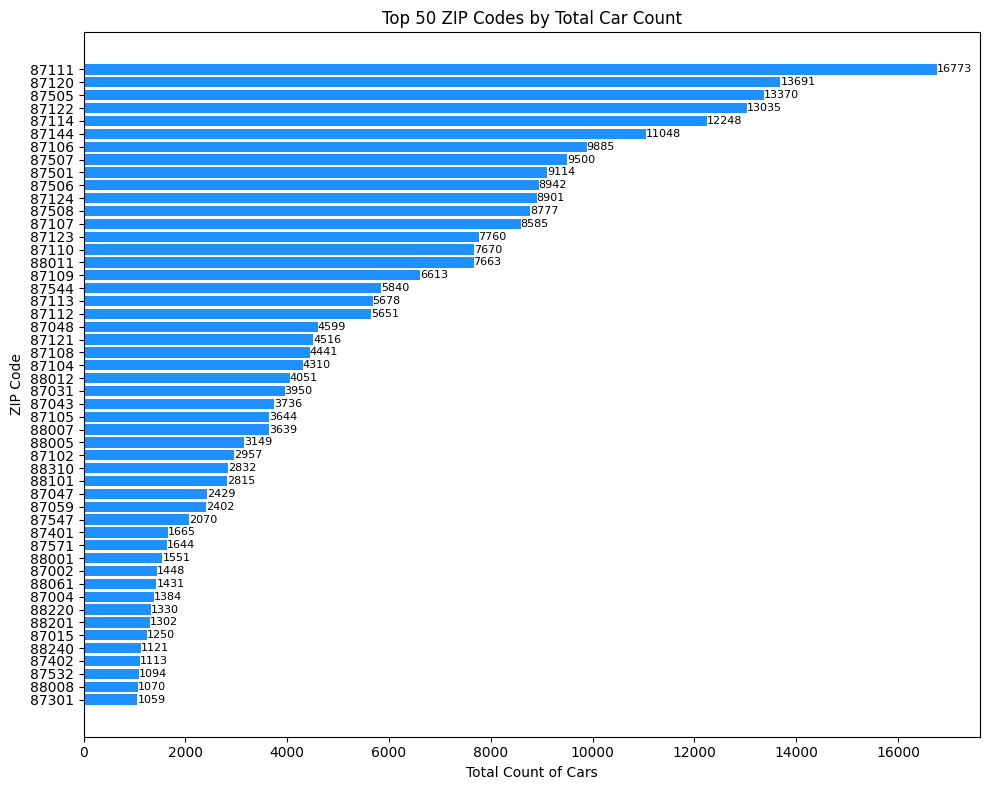

In [ ]:
# Plot only the top 50 ZIP codes (since there are too many zip codes in this dataset)
N = 50
top_n_zipcodes = cars_per_zipcode.sort_values(by='Total Vehicles', ascending=False).head(N)
top_n_zipcodes_sorted = top_n_zipcodes.sort_values(by='Total Vehicles', ascending=True) # Sort for plotting order

plt.figure(figsize=(10, 8))
bars = plt.barh(top_n_zipcodes_sorted['ZIP Code'], top_n_zipcodes_sorted['Total Vehicles'], color='dodgerblue')
plt.xlabel('Total Count of Cars')
plt.ylabel('ZIP Code')
plt.title(f'Top {N} ZIP Codes by Total Car Count')
plt.tight_layout()


# Add car count labels on bars
for bar in bars:
    width = bar.get_width()    # Get the width of the bar (which is the car count)
    y_pos = bar.get_y() + bar.get_height() / 2  # Get the y-position of the bar's center
    plt.text(width, y_pos, f'{int(width)}', va='center', ha='left', fontsize=8, color='black')

plt.show()


- The total number of EVs with latest Snapshot (recently updated)

In [ ]:
# To select only the latest snapshots by filtering out FALSE in the 'Latest DMV Snapshot Flag' column
# Filter the DataFrame where 'Latest DMV Snapshot Flag' is True
filtered_df = ev_regis_df[ev_regis_df['Latest DMV Snapshot Flag'] == True]
filtered_df

,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
30307,NM,87106,3/1/2022,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
30308,NM,88101,3/1/2019,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
30309,NM,87501,9/1/2023,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
30310,NM,87120,9/1/2019,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
30311,NM,87547,12/1/2019,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261098,NM,87505,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True
261107,NM,87507,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True
261116,NM,87112,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True
261121,NM,87120,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True


In [ ]:
filtered_df.shape

(18347, 13)

In [ ]:
ev_df_test2 = filtered_df.copy()

In [ ]:
# Ensure 'ZIP Code' is treated as a string to avoid issues with leading zeros
ev_df_test2['ZIP Code'] = ev_df_test2['ZIP Code'].astype(str)

# Sum 'Vehicle Count' for each unique 'ZIP Code'
cars_per_zipcode_2 = ev_df_test2.groupby('ZIP Code')['Vehicle Count'].sum().reset_index()
cars_per_zipcode_2.rename(columns={'Vehicle Count': 'Total Vehicles'}, inplace=True)

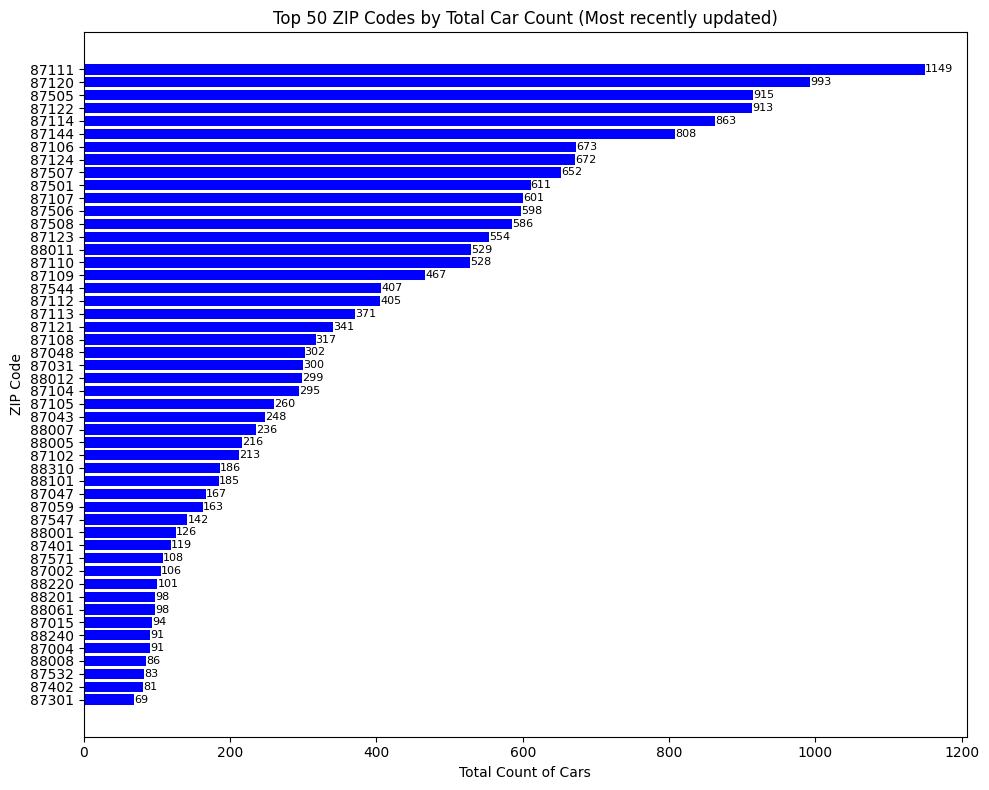

In [ ]:
# Plot only the top 50 ZIP codes
N = 50
top_n_zipcodes_2= cars_per_zipcode_2.sort_values(by='Total Vehicles', ascending=False).head(N)
top_n_zipcodes_sorted_2 = top_n_zipcodes_2.sort_values(by='Total Vehicles', ascending=True) # Sort for plotting order

plt.figure(figsize=(10, 8))
bars_updated = plt.barh(top_n_zipcodes_sorted_2['ZIP Code'], top_n_zipcodes_sorted_2['Total Vehicles'], color='blue')
plt.xlabel('Total Count of Cars')
plt.ylabel('ZIP Code')
plt.title(f'Top {N} ZIP Codes by Total Car Count (Most recently updated)')
plt.tight_layout()

# Add car count labels on bars
for bar in bars_updated:
    width = bar.get_width()    # Get the width of the bar (which is the car count)
    y_pos = bar.get_y() + bar.get_height() / 2  # Get the y-position of the bar's center
    plt.text(width, y_pos, f'{int(width)}', va='center', ha='left', fontsize=8, color='black')

plt.show()


### Extraction of Registration Years

In [ ]:
from datetime import datetime

In [ ]:
# Extract the year from ['Registration Date'] column and create a new column named ['ReleaseYear']
ev_df_test2['Registration Date_temp'] = ev_df_test2['Registration Date'].astype(str).str.strip()

ev_df_test2['Registration Date'] = pd.to_datetime(ev_df_test2['Registration Date'], format='%m/%d/%Y', errors='coerce')
# Find what couldn't be parsed by the first format
#unparsed_mask = ev_df_test2['Registration Date_parsed'].isnull()

# 2. Extract the year into a new column named 'Registration Year'
ev_df_test2['Registration Year'] = ev_df_test2['Registration Date'].dt.year

# 3. Extract the month into a new column named 'Registration Month'
ev_df_test2['Registration Month'] = ev_df_test2['Registration Date'].dt.month

ev_df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18347 entries, 30307 to 261162
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   State                     18347 non-null  object        
 1   ZIP Code                  18347 non-null  object        
 2   Registration Date         18347 non-null  datetime64[ns]
 3   Vehicle Make              18347 non-null  object        
 4   Vehicle Model             18347 non-null  object        
 5   Vehicle Model Year        18347 non-null  int64         
 6   Drivetrain Type           18347 non-null  object        
 7   Vehicle GVWR Class        18347 non-null  object        
 8   Vehicle GVWR Category     18347 non-null  object        
 9   Vehicle Count             18347 non-null  int64         
 10  DMV Snapshot ID           18347 non-null  int64         
 11  DMV Snapshot (Date)       18347 non-null  object        
 12  Latest DMV Snapsho

In [ ]:
# Create a new dataframe: Total cars in each year
ev_zip_and_year = ev_df_test2[['ZIP Code','Vehicle Count','Registration Year']]
ev_zip_and_year

,ZIP Code,Vehicle Count,Registration Year
30307,87106,1,2022
30308,88101,1,2019
30309,87501,1,2023
30310,87120,1,2019
30311,87547,1,2019
...,...,...,...
261098,87505,2,2023
261107,87507,2,2023
261116,87112,2,2023
261121,87120,2,2023


In [ ]:
cars_by_zip_and_year_sorted = ev_zip_and_year.sort_values(by=['ZIP Code', 'Registration Year']).reset_index(drop=True)



print("DataFrame to compare:")
print(cars_by_zip_and_year_sorted.head(10)) # Displaying first 10 rows

DataFrame to compare:
  ZIP Code  Vehicle Count  Registration Year
0    33309              1               2024
1    60016              1               2024
2    60016              1               2024
3    60016              1               2025
4    60048              1               2025
5    87001              1               2023
6    87001              1               2023
7    87001              1               2024
8    87001              1               2024
9    87001              1               2024


In [ ]:
# Group by 'ZIP Code' and 'Registration Year' and sum 'Vehicle Count'
cars_by_zip_and_year = ev_df_test2.groupby(['ZIP Code', 'Registration Year'])['Vehicle Count'].sum().reset_index()

# Rename the column for clarity
cars_by_zip_and_year.rename(columns={'Vehicle Count': 'Total Cars'}, inplace=True)

# Display the result
print("Total cars grouped by ZIP Code and Registration Year:")
print(cars_by_zip_and_year)

# You might want to sort it for better readability
cars_by_zip_and_year_sorted = cars_by_zip_and_year.sort_values(by=['ZIP Code', 'Registration Year']).reset_index(drop=True)
print("\nSorted results:")
print(cars_by_zip_and_year_sorted)

Total cars grouped by ZIP Code and Registration Year:
     ZIP Code  Registration Year  Total Cars
0       33309               2024           1
1       60016               2024           2
2       60016               2025           1
3       60048               2025           1
4       87001               2023           2
...       ...                ...         ...
1022    88435               2022           3
1023    88435               2023           1
1024    88435               2024           3
1025    88435               2025           2
1026    97209               2024           2

[1027 rows x 3 columns]

Sorted results:
     ZIP Code  Registration Year  Total Cars
0       33309               2024           1
1       60016               2024           2
2       60016               2025           1
3       60048               2025           1
4       87001               2023           2
...       ...                ...         ...
1022    88435               2022           3
1023

In [ ]:
# Pivot table with ZIP codes as rows and Years as columns
pivot_table = cars_by_zip_and_year_sorted.pivot_table(
    index='ZIP Code',
    columns='Registration Year',
    values='Total Cars',
    fill_value=0 # Fill years with no data for a ZIP code with 0
)

print("\nPivot Table: Total Cars by ZIP Code (rows) and Year (columns)")
print(pivot_table)


Pivot Table: Total Cars by ZIP Code (rows) and Year (columns)
Registration Year  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  \
ZIP Code                                                                        
33309               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
60016               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
60048               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
87001               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
87002               0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   3.0   5.0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
88427               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
88431               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
88434               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
88435               0.0   0.0   0.0   0.0   0.

Reference for zip codes in ABQ:

[GISGeography](https://gisgeography.com/albuquerque-zip-code-map/)

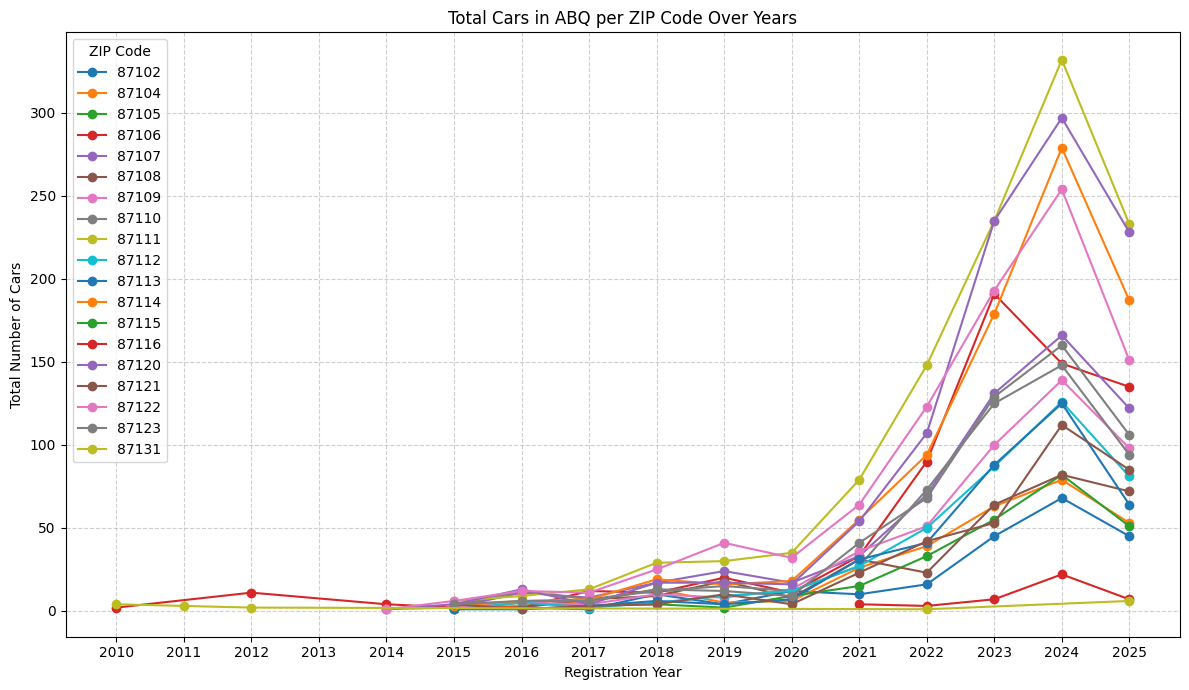

In [ ]:
zip_abq = ['87102','87104','87105','87106','87107','87108','87109','87110','87111','87112','87113','87114','87115','87116', '87120', '87121', '87122', '87123','87131']

plt.figure(figsize=(12, 7))

# Select a few ZIP codes to plot
#zip_codes_to_plot = cars_by_zip_and_year_sorted['ZIP Code'].value_counts().nlargest(20).index.tolist() # Top 20 ZIPs by total cars

for zip_code in zip_abq:
    subset = cars_by_zip_and_year_sorted[cars_by_zip_and_year_sorted['ZIP Code'] == zip_code]
    plt.plot(subset['Registration Year'], subset['Total Cars'], marker='o', label={zip_code})

plt.xlabel('Registration Year')
plt.ylabel('Total Number of Cars')
plt.title('Total Cars in ABQ per ZIP Code Over Years')
plt.xticks(cars_by_zip_and_year_sorted['Registration Year'].unique().astype(int)) # Ensure integer years on x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='ZIP Code')
plt.tight_layout()
plt.show()

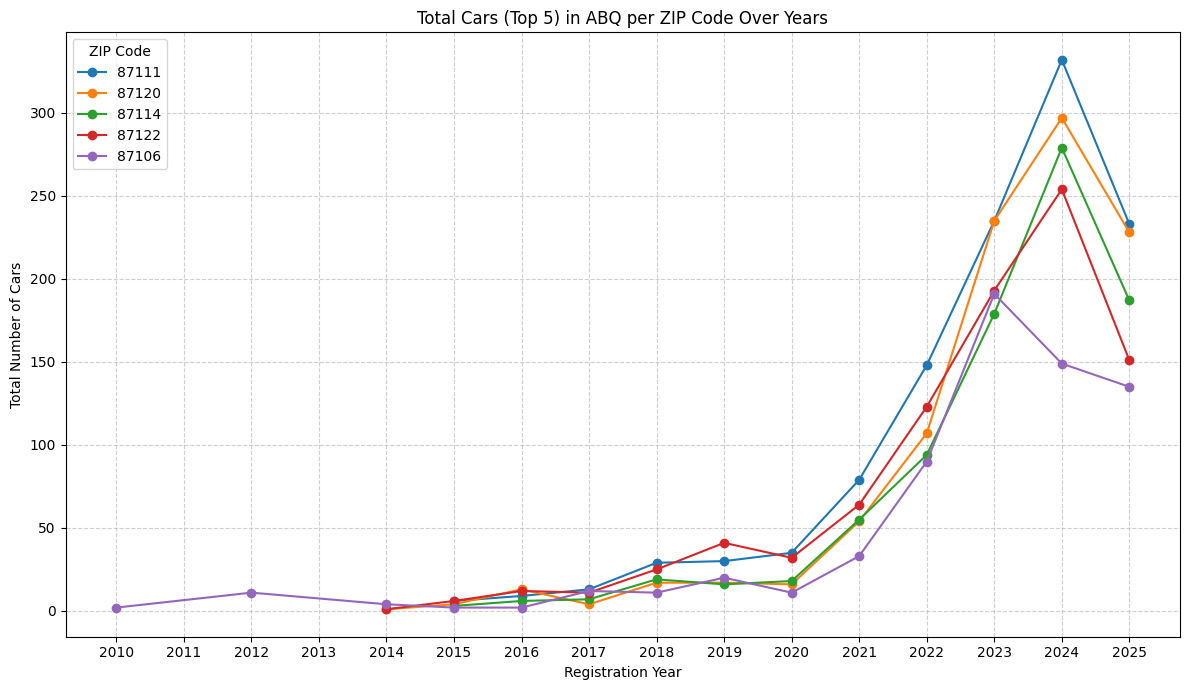

In [ ]:
zip_abq_5 = ['87111', '87120', '87114', '87122', '87106']

plt.figure(figsize=(12, 7))

# Select a few ZIP codes to plot
#zip_codes_to_plot = cars_by_zip_and_year_sorted['ZIP Code'].value_counts().nlargest(20).index.tolist() # Top 20 ZIPs by total cars

for zip_code in zip_abq_5:
    subset2 = cars_by_zip_and_year_sorted[cars_by_zip_and_year_sorted['ZIP Code'] == zip_code]
    plt.plot(subset2['Registration Year'], subset2['Total Cars'], marker='o', label={zip_code})

plt.xlabel('Registration Year')
plt.ylabel('Total Number of Cars')
plt.title('Total Cars (Top 5) in ABQ per ZIP Code Over Years')
plt.xticks(cars_by_zip_and_year_sorted['Registration Year'].unique().astype(int)) # Ensure integer years on x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='ZIP Code')
plt.tight_layout()
plt.show()

### Data Preparation for Time Series

- The goal is to get a time series of EV counts. From your data, the most relevant columns will be Registration Date (to derive a time index) and Vehicle Count.

In [ ]:
ev_df_model1 = ev_df_test2.copy()

In [ ]:
# Use the previously converted datatype operation dataframe named ev_df_test2
# Step 1: Set 'Registration Date' as the DataFrame index (for time series operations):
ev_df_ts = ev_df_model1.set_index('Registration Date')

- This will create a time series where each entry is the total number of vehicles registered in that month.

In [ ]:
# Resample to monthly frequency and sum 'Vehicle Count':
# 'MS' means Month Start frequency
monthly_ev_counts = ev_df_ts['Vehicle Count'].resample('MS').sum()
print("Monthly EV Counts Series:")
monthly_ev_counts.head()


Monthly EV Counts Series:


,Vehicle Count
Registration Date,
2010-05-01,2
2010-06-01,4
2010-07-01,3
2010-08-01,0
2010-09-01,1


In [ ]:
monthly_ev_counts.tail()

,Vehicle Count
Registration Date,
2025-03-01,582
2025-04-01,709
2025-05-01,664
2025-06-01,583
2025-07-01,37


- If there are months with no registrations, resample might not create an entry. fill_value(0) can ensure continuity.

In [ ]:
# Handle missing values:
monthly_ev_counts = ev_df_ts['Vehicle Count'].resample('MS').sum().fillna(0)

In [ ]:
monthly_ev_counts.isnull().sum()

np.int64(0)

## Data Processing

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

## Train data from 2010 to 2024


Workflow:
1. Training Data: 2010 to 2024 (inclusive).

2. Testing Data (for evaluation): January 2025 to July 2025.

3. Future Prediction: August 2025 to July 2026.

In [ ]:
# --- 1. Recreate Sample monthly_ev_counts Data for Demonstration ---
# Your actual monthly_ev_counts should already be created from your DataFrame.
# Ensure its index is datetime objects and it covers the period from 2010 to July 2025.

# Sample data generation (replace this with your actual monthly_ev_counts)
dates = pd.date_range(start='2010-01-01', end='2025-07-01', freq='MS')
np.random.seed(42)
# Simulate increasing trend, seasonality, and some noise
counts = (np.linspace(50, 550, len(dates)) +
          80 * np.sin(np.arange(len(dates)) * 2 * np.pi / 12) + # Annual seasonality
          40 * np.cos(np.arange(len(dates)) * 2 * np.pi / 6) +  # Semi-annual seasonality
          np.random.normal(0, 40, len(dates)))
counts[counts < 0] = 0 # Ensure no negative counts
monthly_ev_counts = pd.Series(counts.astype(int), index=dates)

print("Sample monthly_ev_counts data head and tail:")
print(monthly_ev_counts.head())
print(monthly_ev_counts.tail())
print(f"Full data range: {monthly_ev_counts.index.min()} to {monthly_ev_counts.index.max()}")

Sample monthly_ev_counts data head and tail:
2010-01-01    109
2010-02-01    107
2010-03-01    130
2010-04-01    158
2010-05-01    100
Freq: MS, dtype: int64
2025-03-01    545
2025-04-01    601
2025-05-01    584
2025-06-01    635
2025-07-01    608
Freq: MS, dtype: int64
Full data range: 2010-01-01 00:00:00 to 2025-07-01 00:00:00


### Create a model

In [ ]:
# Training data: 2010 to 2024
train_end_date = '2024-12-01' # End of 2024
train_data = monthly_ev_counts.loc[monthly_ev_counts.index <= train_end_date]

# Testing data (for evaluation): Jan 2025 to July 2025
test_start_date = '2025-01-01'
test_end_date = '2025-07-01' # July 2025
test_data = monthly_ev_counts.loc[(monthly_ev_counts.index >= test_start_date) & (monthly_ev_counts.index <= test_end_date)]

# Future prediction period: Aug 2025 to July 2026
forecast_start_date_future = '2025-08-01' # August 2025
forecast_end_date_future = '2026-07-01' # July 2026
future_forecast_index = pd.date_range(start=forecast_start_date_future, end=forecast_end_date_future, freq='MS')
num_future_steps = len(future_forecast_index)


print(f"\nTraining data range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data range: {test_data.index.min()} to {test_data.index.max()}")
print(f"Future forecast range: {future_forecast_index.min()} to {future_forecast_index.max()}")




Training data range: 2010-01-01 00:00:00 to 2024-12-01 00:00:00
Testing data range: 2025-01-01 00:00:00 to 2025-07-01 00:00:00
Future forecast range: 2025-08-01 00:00:00 to 2026-07-01 00:00:00


### Train and Fit the model

In [ ]:
# --- 3. SARIMA Model Training ---

# (p,d,q)(P,D,Q,S) parameters. S=12 for monthly seasonality.
# Either use the auto_arima or ACF/PACF plots to get optimal parameter.
# Start with these auto parameters:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

print("\nFitting SARIMA model on training data (2010-2024)...")
try:
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    print("Model fitting complete.")
    # print(model_fit.summary()) # Uncomment to see full summary
except Exception as e:
    print(f"Error fitting SARIMA model: {e}")
    print("Consider trying different SARIMA parameters or using auto_arima.")
    exit() # Stop if model can't be fitted



Fitting SARIMA model on training data (2010-2024)...
Model fitting complete.


### Data Prediction and Evauation the model

In [ ]:
# --- 4. Predict and Evaluate for the Test Period (Jan 2025 - July 2025) ---

# Get predictions for the test period
# The 'start' and 'end' parameters for get_prediction should be actual dates/indices
prediction_results_test = model_fit.get_prediction(start=test_start_date, end=test_end_date)
predictions_test = prediction_results_test.predicted_mean
conf_int_test = prediction_results_test.conf_int(alpha=0.05)

print("\nPredictions for Test Period (Jan 2025 - July 2025):")
print(predictions_test)


Predictions for Test Period (Jan 2025 - July 2025):
2025-01-01    573.374201
2025-02-01    595.402721
2025-03-01    567.975985
2025-04-01    589.624354
2025-05-01    593.280841
2025-06-01    636.451067
2025-07-01    604.281526
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
# Evaluate the model using RMSE for the test period
rmse = np.sqrt(mean_squared_error(test_data, predictions_test))
print(f"\nRMSE for Test Period (Jan 2025 - July 2025): {rmse:.2f}")


RMSE for Test Period (Jan 2025 - July 2025): 18.83


In [ ]:
# --- 5. Predict for the Future Period (Aug 2025 - July 2026) ---

# Get forecasts for the specified future period
# Use the `start` and `end` parameters for get_prediction to specify the forecast range
prediction_results_future = model_fit.get_prediction(start=forecast_start_date_future, end=forecast_end_date_future)
predictions_future = prediction_results_future.predicted_mean
conf_int_future = prediction_results_future.conf_int(alpha=0.05)


print(f"\nForecasted EV car counts for Aug 2025 - July 2026:")
print(predictions_future)



Forecasted EV car counts for Aug 2025 - July 2026:
2025-08-01    540.689728
2025-09-01    473.841501
2025-10-01    450.679216
2025-11-01    490.659390
2025-12-01    561.530434
2026-01-01    620.113873
2026-02-01    626.641337
2026-03-01    601.671140
2026-04-01    622.549168
2026-05-01    626.930409
2026-06-01    669.854780
2026-07-01    637.907054
Freq: MS, Name: predicted_mean, dtype: float64


## Data Visualization

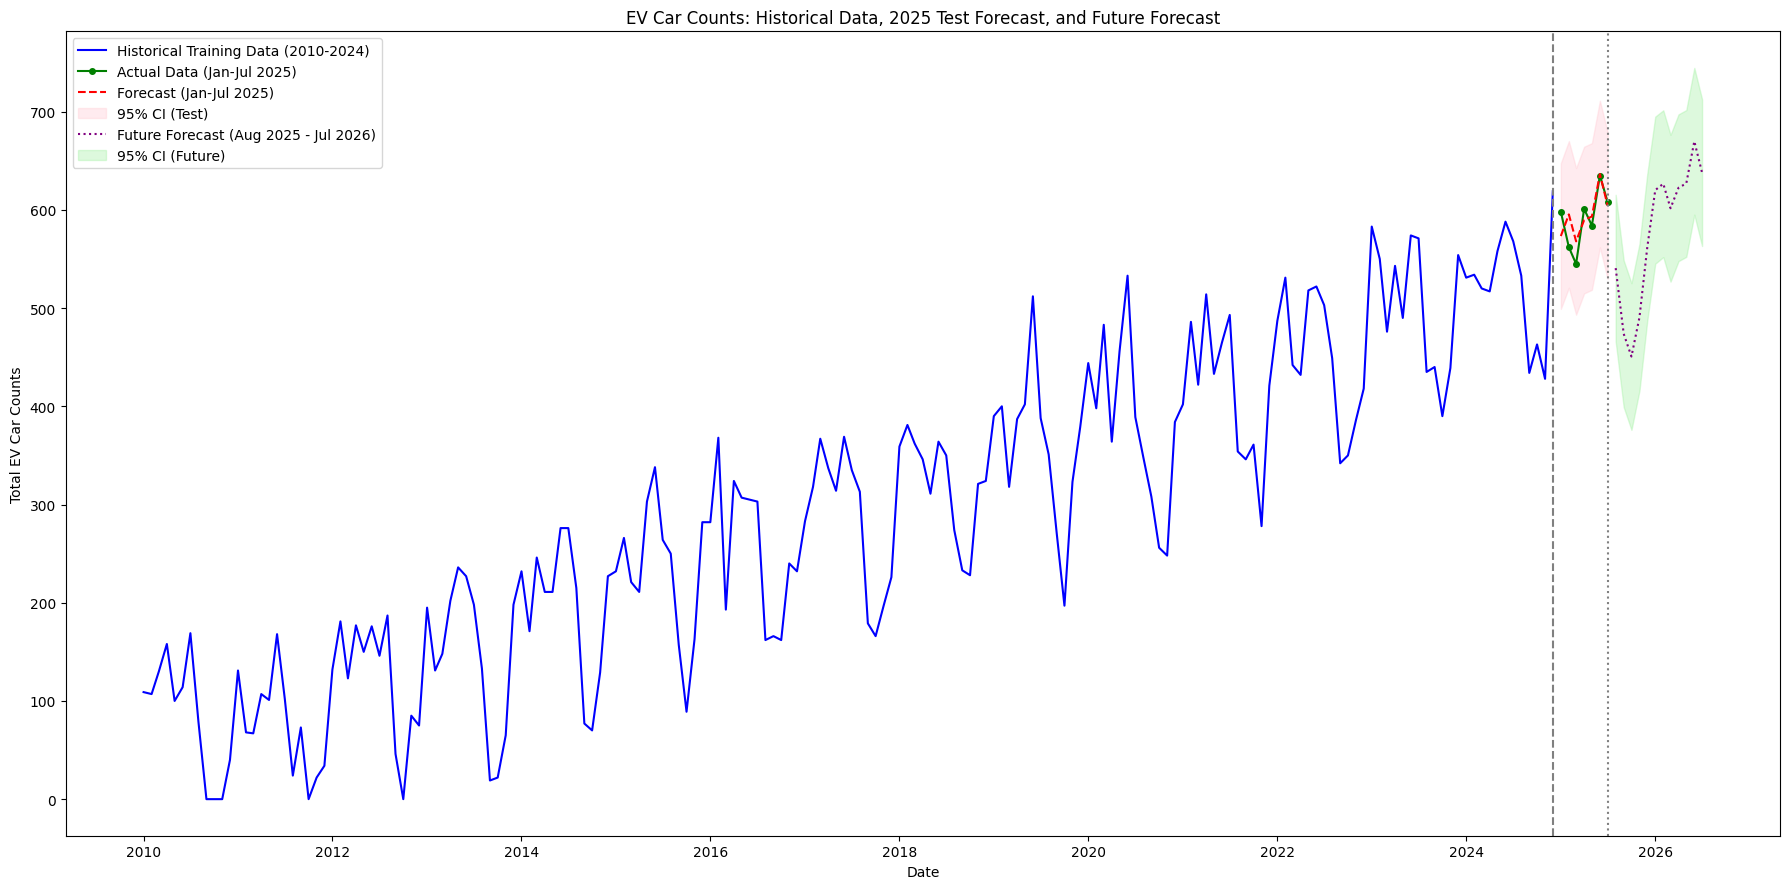

In [ ]:
# --- 6. Visualization ---

plt.figure(figsize=(18, 9))

# Plot historical training data
plt.plot(train_data.index, train_data, label='Historical Training Data (2010-2024)', color='blue', linewidth=1.5)

# Plot actual test data for 2025
plt.plot(test_data.index, test_data, label='Actual Data (Jan-Jul 2025)', color='green', linewidth=1.5, marker='o', markersize=4)

# Plot predictions for the test period
plt.plot(predictions_test.index, predictions_test, label='Forecast (Jan-Jul 2025)', color='red', linestyle='--', linewidth=1.5)
plt.fill_between(conf_int_test.index, conf_int_test.iloc[:, 0], conf_int_test.iloc[:, 1], color='pink', alpha=0.3, label='95% CI (Test)')

# Plot future predictions
plt.plot(predictions_future.index, predictions_future, label='Future Forecast (Aug 2025 - Jul 2026)', color='purple', linestyle=':', linewidth=1.5)
plt.fill_between(conf_int_future.index, conf_int_future.iloc[:, 0], conf_int_future.iloc[:, 1], color='lightgreen', alpha=0.3, label='95% CI (Future)')

plt.title('EV Car Counts: Historical Data, 2025 Test Forecast, and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Total EV Car Counts')
plt.legend()
plt.grid(False)
plt.axvline(x=train_data.index.max(), color='grey', linestyle='--', label='Training End (2024-12)')
plt.axvline(x=test_data.index.max(), color='grey', linestyle=':', label='Test End (2025-07)')
plt.tight_layout()
plt.show()


# Zoom-In data (Monthly in 2025)

## Step 1: Prepare Monthly EV Counts per ZIP Code

- First, aggregate the original dataframe (ev_df_test2) to get monthly Vehicle

- Count sums for each unique ZIP Code.

In [ ]:
ev_df_model2 = ev_df_test2.copy()

In [ ]:
# Define the specific ZIP codes for Albuquerque
#zip_abq = ['87102','87104','87105','87106','87107','87108','87109','87110','87111','87112','87113','87114','87115','87116', '87120', '87121', '87122', '87123','87131']


In [ ]:
# Filter for ABQ ZIP codes
#ev_df_abq = ev_df_model2[ev_df_model2['ZIP Code'].isin(zip_abq)].copy()

In [ ]:
# Set 'Registration Date' as index and resample by month for each ABQ ZIP Code
monthly_ev_counts_by_zip = ev_df_model2.set_index('Registration Date') \
                                   .groupby('ZIP Code')['Vehicle Count'] \
                                   .resample('MS') \
                                   .sum() \
                                   .fillna(0) # Fill months with no registrations with 0

print("Monthly EV Counts for ABQ ZIPs (Head):")
print(monthly_ev_counts_by_zip.head(10))

Monthly EV Counts for ABQ ZIPs (Head):
ZIP Code  Registration Date
33309     2024-05-01           1
60016     2024-12-01           2
          2025-01-01           1
60048     2025-06-01           1
87001     2023-09-01           1
          2023-10-01           1
          2023-11-01           0
          2023-12-01           0
          2024-01-01           0
          2024-02-01           0
Name: Vehicle Count, dtype: int64


### All zip codes in ABQ

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

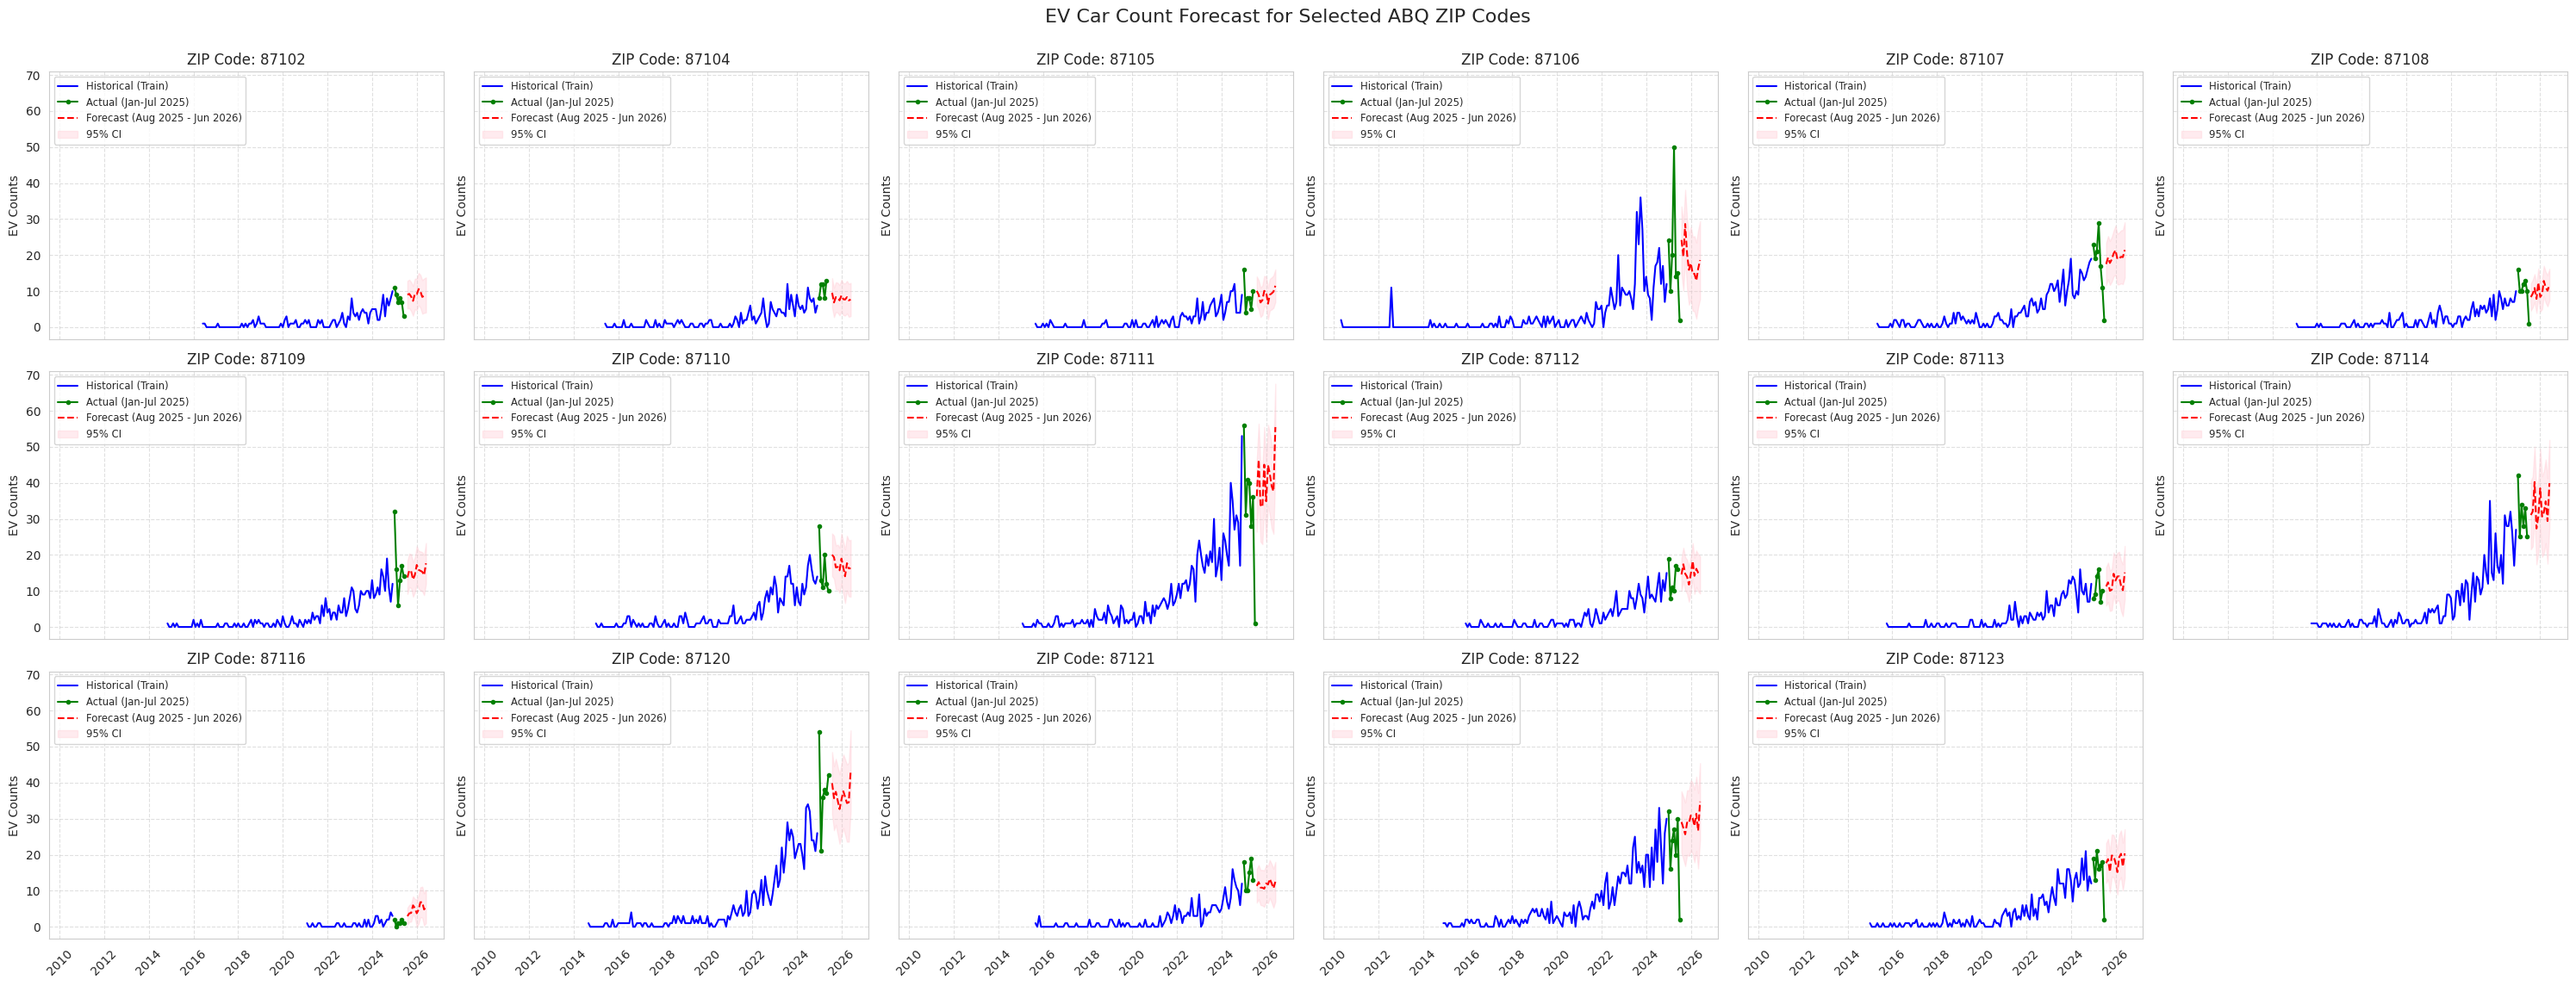

In [ ]:
# Define the specific ZIP codes for Albuquerque
zip_abq = ['87102','87104','87105','87106','87107','87108','87109','87110','87111','87112','87113','87114','87115','87116', '87120', '87121', '87122', '87123']

# --- Recreate Data Preparation and Prediction for demonstration ---
# This part should be replaced by your actual data loading and model fitting results.
# Ensure 'ev_df' is loaded from your data source.

# Sample data generation (replace with your actual data loading/processing)
np.random.seed(42)
num_rows = 5000
# Ensure sample_dates go up to July 2025 for actuals and then extend for prediction
sample_dates = pd.date_range(start='2020-01-01', end='2025-07-01', freq='D')

# Filter for ABQ ZIP codes
ev_df_abq = ev_df_model2[ev_df_model2['ZIP Code'].isin(zip_abq)].copy()

monthly_ev_counts_by_zip = ev_df_abq.set_index('Registration Date') \
                                   .groupby('ZIP Code')['Vehicle Count'] \
                                   .resample('MS') \
                                   .sum() \
                                   .fillna(0)


# Define periods
train_end_date = '2024-12-01'
forecast_start_date_future = '2025-08-01'
forecast_end_date_future = '2026-06-01'
future_forecast_index = pd.date_range(start=forecast_start_date_future, end=forecast_end_date_future, freq='MS')

# Model parameters (same as before, replace with your tuned parameters)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

zip_code_predictions = {}
zip_code_confidence_intervals = {}

unique_zip_codes_to_process = [zip for zip in zip_abq if zip in monthly_ev_counts_by_zip.index.get_level_values('ZIP Code').unique()]

for zip_code in unique_zip_codes_to_process:
    zip_ts = monthly_ev_counts_by_zip.loc[zip_code]
    train_data_zip = zip_ts.loc[zip_ts.index.year <= 2024]

    if len(train_data_zip) < 24: # Require at least 2 years for SARIMA (2*12 months)
        zip_code_predictions[zip_code] = pd.Series(np.nan, index=future_forecast_index)
        zip_code_confidence_intervals[zip_code] = pd.DataFrame(np.nan, index=future_forecast_index, columns=['lower', 'upper'])
        continue

    try:
        model = SARIMAX(train_data_zip, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, maxiter=50)

        prediction_results_future = model_fit.get_prediction(
            start=future_forecast_index.min(),
            end=future_forecast_index.max()
        )
        predictions_zip = prediction_results_future.predicted_mean
        conf_int_zip = prediction_results_future.conf_int(alpha=0.05)

        zip_code_predictions[zip_code] = predictions_zip
        zip_code_confidence_intervals[zip_code] = conf_int_zip

    except Exception as e:
        # print(f"  Error for ZIP {zip_code}: {e}") # Uncomment for debugging
        zip_code_predictions[zip_code] = pd.Series(np.nan, index=future_forecast_index)
        zip_code_confidence_intervals[zip_code] = pd.DataFrame(np.nan, index=future_forecast_index, columns=['lower', 'upper'])

# Convert predictions to a DataFrame (wide format)
predicted_df_wide = pd.DataFrame(zip_code_predictions)

# --- Visualization ---

# Set a style for the plots
sns.set_style("whitegrid")

# Determine the number of subplots needed
num_zips = len(unique_zip_codes_to_process)
# Calculate grid size: roughly square or wide rectangular layout
cols = 6 # Number of columns in the grid
rows = (num_zips + cols - 1) // cols # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True, sharey=True) # sharey=False because counts might vary wildly
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Get the overall date range for consistent x-axis limits if desired
#all_dates = pd.date_range(start=monthly_ev_counts_by_zip.index.min(), end=forecast_end_date_future, freq='MS')

# Loop through each ZIP code and plot its historical data and predictions
for i, zip_code in enumerate(unique_zip_codes_to_process):
    if i >= len(axes): # In case there are more ZIPs than subplots created
        break

    ax = axes[i]

    # Get historical data for the current ZIP code
    historical_data_zip = monthly_ev_counts_by_zip.loc[zip_code]
    train_data_zip = historical_data_zip.loc[historical_data_zip.index.year <= 2024]
    test_data_zip = historical_data_zip.loc[(historical_data_zip.index.year == 2025) & (historical_data_zip.index.month <= 7)]

    # Get predictions for the current ZIP code
    predictions_zip = predicted_df_wide[zip_code]
    conf_int_zip = zip_code_confidence_intervals[zip_code]

    # Plot historical training data
    ax.plot(train_data_zip.index, train_data_zip, label='Historical (Train)', color='blue', linewidth=1.5)

    # Plot actual 2025 data (if available for evaluation)
    if not test_data_zip.empty:
        ax.plot(test_data_zip.index, test_data_zip, label='Actual (Jan-Jul 2025)', color='green', linewidth=1.5, marker='o', markersize=3)

    # Plot future predictions
    ax.plot(predictions_zip.index, predictions_zip, label='Forecast (Aug 2025 - Jun 2026)', color='red', linestyle='--', linewidth=1.5)

    # Plot confidence interval
    if not conf_int_zip.empty:
        ax.fill_between(conf_int_zip.index, conf_int_zip.iloc[:, 0], conf_int_zip.iloc[:, 1], color='pink', alpha=0.3, label='95% CI')

    ax.set_title(f'ZIP Code: {zip_code}')
    ax.set_ylabel('EV Counts')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left', fontsize='small')

    # Set x-axis limits to cover the entire relevant period
    # ax.set_xlim(all_dates.min(), all_dates.max()) # Optional: set consistent x-limits
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
fig.suptitle('EV Car Count Forecast for Selected ABQ ZIP Codes', fontsize=16, y=0.98)
plt.show()

### Top 3 populated areas of EV users

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error # Import RMSE

In [ ]:
ev_df_model3 = ev_df_test2.copy()

In [ ]:
# Define the specific ZIP codes for Albuquerque
zip_abq_top3 = ['87111','87120', '87114']

# Sample data generation (replace with the actual data loading)
np.random.seed(42)
num_rows = 10000
all_dates = pd.date_range(start='2010-01-01', end='2025-07-01', freq='D')


# Filter for ABQ ZIP codes
ev_df_abq_top3_filtered = ev_df_model3[ev_df_model3['ZIP Code'].isin(zip_abq_top3)].copy()

monthly_ev_counts_by_zip_top3 = ev_df_abq_top3_filtered.set_index('Registration Date') \
                                   .groupby('ZIP Code')['Vehicle Count'] \
                                   .resample('MS') \
                                   .sum() \
                                   .fillna(0) # Fill missing months with 0

print("Sample monthly_ev_counts per zip code (MultiIndex Series) head and tail:")
print(monthly_ev_counts_by_zip_top3.head())
print(monthly_ev_counts_by_zip_top3.tail())
# Accessing date range from the MultiIndex
print(f"Full data range (overall): {monthly_ev_counts_by_zip_top3.index.get_level_values('Registration Date').min()} to {monthly_ev_counts_by_zip_top3.index.get_level_values('Registration Date').max()}")



Sample monthly_ev_counts per zip code (MultiIndex Series) head and tail:
ZIP Code  Registration Date
87111     2015-02-01           1
          2015-03-01           0
          2015-04-01           0
          2015-05-01           0
          2015-06-01           0
Name: Vehicle Count, dtype: int64
ZIP Code  Registration Date
87120     2025-02-01           21
          2025-03-01           36
          2025-04-01           38
          2025-05-01           37
          2025-06-01           42
Name: Vehicle Count, dtype: int64
Full data range (overall): 2014-09-01 00:00:00 to 2025-07-01 00:00:00


In [ ]:
# Define periods
# Training data: 2020-01-01 to 2025-07-01 (inclusive)
train_start_date = pd.to_datetime('2020-01-01')
train_end_date = pd.to_datetime('2025-07-01')

# Testing data (for evaluation): 2025-01-01 to 2025-07-01 (inclusive)
test_start_date = pd.to_datetime('2020-01-01')
test_end_date = pd.to_datetime('2025-07-01')

# Future prediction period: 2025-08-01 to 2026-07-01 (inclusive)
# Prediction starts the month *after* training ends
forecast_start_date_future = train_end_date + pd.DateOffset(months=1) # This will be 2025-08-01
forecast_end_date_future = pd.to_datetime('2026-07-01')
future_forecast_index = pd.date_range(start=forecast_start_date_future, end=forecast_end_date_future, freq='MS')


print(f"\nOverall Training data range: {train_start_date} to {train_end_date}")
print(f"Overall Testing data range: {test_start_date} to {test_end_date}")
print(f"Overall Future forecast range: {future_forecast_index.min()} to {future_forecast_index.max()}")



Overall Training data range: 2020-01-01 00:00:00 to 2025-07-01 00:00:00
Overall Testing data range: 2020-01-01 00:00:00 to 2025-07-01 00:00:00
Overall Future forecast range: 2025-08-01 00:00:00 to 2026-07-01 00:00:00


#### Model Training and Prediction

In [ ]:
# Model parameters (tune these for optimal performance!)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

zip_code_predictions = {}
zip_code_confidence_intervals = {}
zip_code_rmse = {} # Dictionary to store RMSE for each ZIP code
zip_code_test_predictions = {} # Dictionary to store test period predictions for plotting

print(f"\nStarting prediction for {len(zip_abq_top3)} specified ABQ ZIP codes...")

for zip_code in zip_abq_top3: # Loop through top 3 ZIPs
    print(f"\nProcessing ZIP Code: {zip_code}")

    # Extract the time series for the current ZIP code
    # This correctly slices the MultiIndex Series
    zip_ts = monthly_ev_counts_by_zip_top3.loc[zip_code]

    # Filter training data for the current ZIP code based on new range
    train_data_zip = zip_ts.loc[(zip_ts.index >= train_start_date) & (zip_ts.index <= train_end_date)]

    # Filter actual test data for the current ZIP code
    # This is the data we will compare our test predictions against
    actual_test_data_zip = zip_ts.loc[(zip_ts.index >= test_start_date) & (zip_ts.index <= test_end_date)]


    # Data sufficiency check for training
    if len(train_data_zip) < 2 * 12: # At least 2 years of data for seasonality
        print(f"  Skipping ZIP {zip_code}: Not enough historical training data ({len(train_data_zip)} data points from {train_start_date} to {train_end_date}).")
        zip_code_predictions[zip_code] = pd.Series(np.nan, index=future_forecast_index)
        zip_code_confidence_intervals[zip_code] = pd.DataFrame(np.nan, index=future_forecast_index, columns=['lower', 'upper'])
        zip_code_rmse[zip_code] = np.nan # No RMSE if skipped
        zip_code_test_predictions[zip_code] = pd.Series(np.nan, index=actual_test_data_zip.index) # Store NaNs for test predictions too
        continue

    # Fit SARIMA model for the current ZIP code
    try:
        model = SARIMAX(train_data_zip, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, maxiter=100)
        print(f"  Model for ZIP {zip_code} fitted successfully. Training data from {train_data_zip.index.min()} to {train_data_zip.index.max()}")

        # --- Predict for the Test Period (Jan 2025 - Jul 2025) ---
        # This prediction is for evaluation against actual_test_data_zip
        prediction_results_test = model_fit.get_prediction(
            start=test_start_date,
            end=test_end_date
        )
        predictions_test_zip = prediction_results_test.predicted_mean
        zip_code_test_predictions[zip_code] = predictions_test_zip # Store for plotting

        # Calculate RMSE for the test period
        if not actual_test_data_zip.empty and not predictions_test_zip.empty:
            # Align indices to ensure correct comparison
            common_index = predictions_test_zip.index.intersection(actual_test_data_zip.index)
            if not common_index.empty:
                rmse = np.sqrt(mean_squared_error(actual_test_data_zip[common_index], predictions_test_zip[common_index]))
                zip_code_rmse[zip_code] = rmse
                print(f"  RMSE for test period (Jan-Jul 2025) for ZIP {zip_code}: {rmse:.2f}")
            else:
                zip_code_rmse[zip_code] = np.nan
                print(f"  No overlapping data for RMSE calculation for ZIP {zip_code}.")
        else:
            zip_code_rmse[zip_code] = np.nan
            print(f"  No actual test data or predictions for RMSE calculation for ZIP {zip_code}.")


        # --- Predict for the Future Period (Aug 2025 - Jul 2026) ---
        prediction_results_future = model_fit.get_prediction(
            start=future_forecast_index.min(),
            end=future_forecast_index.max()
        )
        predictions_zip = prediction_results_future.predicted_mean
        conf_int_zip = prediction_results_future.conf_int(alpha=0.05)

        zip_code_predictions[zip_code] = predictions_zip
        zip_code_confidence_intervals[zip_code] = conf_int_zip

    except Exception as e:
        print(f"  Error fitting or predicting for ZIP {zip_code}: {e}")
        zip_code_predictions[zip_code] = pd.Series(np.nan, index=future_forecast_index)
        zip_code_confidence_intervals[zip_code] = pd.DataFrame(np.nan, index=future_forecast_index, columns=['lower', 'upper'])
        zip_code_rmse[zip_code] = np.nan
        zip_code_test_predictions[zip_code] = pd.Series(np.nan, index=actual_test_data_zip.index)

# Convert predictions to a DataFrame (wide format)
predicted_df_top3 = pd.DataFrame(zip_code_predictions)

print("\nRMSE for each ZIP Code in the test period:")
print(zip_code_rmse)


Starting prediction for 3 specified ABQ ZIP codes...

Processing ZIP Code: 87111


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Model for ZIP 87111 fitted successfully. Training data from 2020-01-01 00:00:00 to 2025-07-01 00:00:00
  RMSE for test period (Jan-Jul 2025) for ZIP 87111: 7.07

Processing ZIP Code: 87120


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Model for ZIP 87120 fitted successfully. Training data from 2020-01-01 00:00:00 to 2025-06-01 00:00:00
  RMSE for test period (Jan-Jul 2025) for ZIP 87120: 5.46

Processing ZIP Code: 87114


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Model for ZIP 87114 fitted successfully. Training data from 2020-01-01 00:00:00 to 2025-06-01 00:00:00
  RMSE for test period (Jan-Jul 2025) for ZIP 87114: 5.25

RMSE for each ZIP Code in the test period:
{'87111': np.float64(7.065071310317634), '87120': np.float64(5.457921471055506), '87114': np.float64(5.247464117938836)}


In [ ]:
predicted_df_top3

,87111,87120,87114
2025-08-01,38.858036,48.286389,34.083838
2025-09-01,43.233521,43.370760,33.012208
2025-10-01,25.991354,45.665926,48.970023
2025-11-01,34.104801,43.458267,31.627482
2025-12-01,22.466110,39.389219,32.526246
2026-01-01,9.534136,42.123181,46.058859
2026-02-01,41.055453,43.985979,35.084667
2026-03-01,31.610058,43.165637,35.738859
2026-04-01,26.583153,41.022116,38.067381
2026-05-01,30.835067,39.460817,33.243094


#### Data Visualization

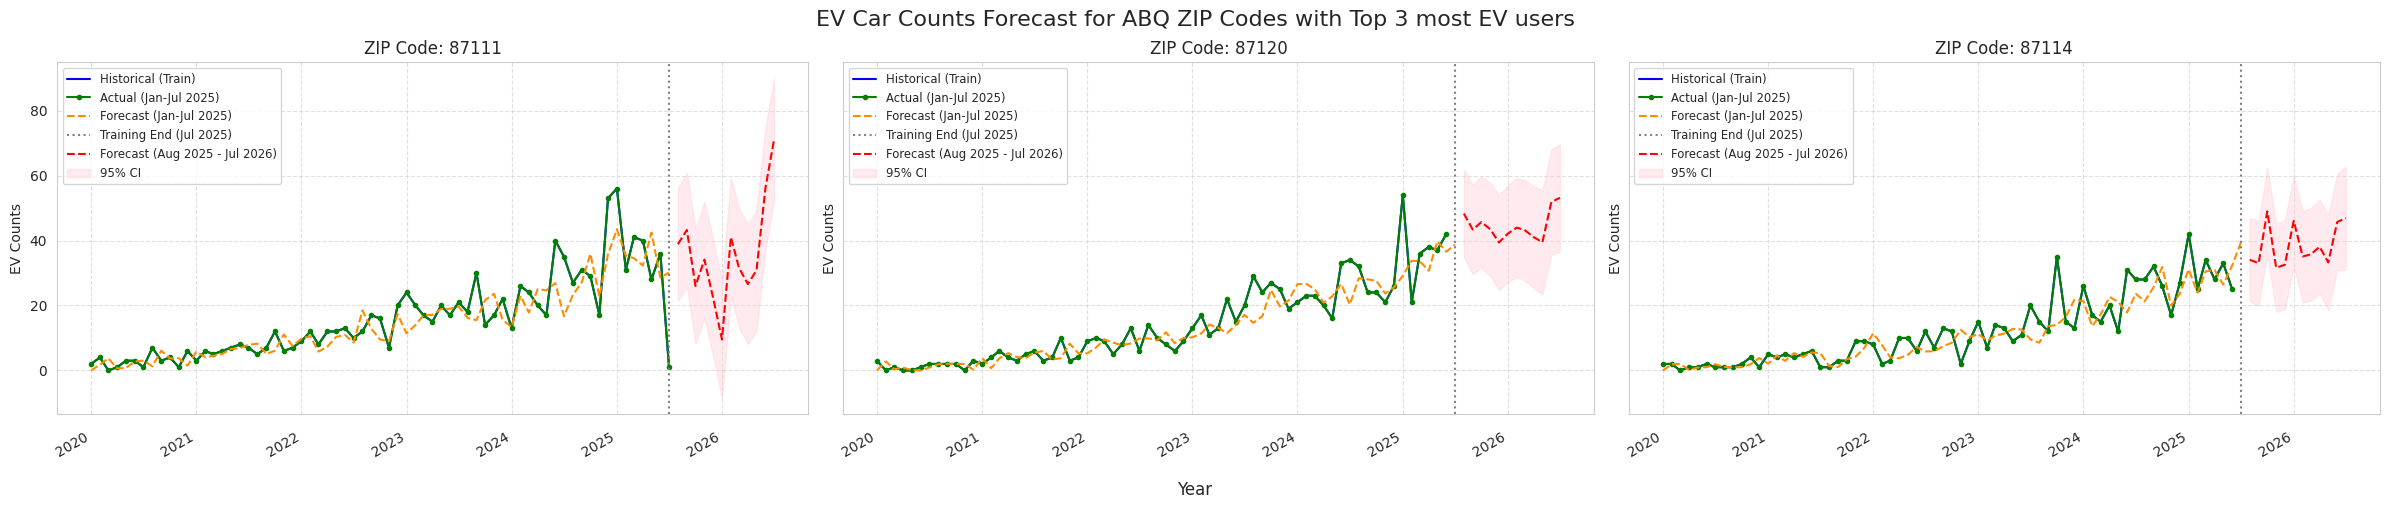

In [ ]:
# --- Visualization ---

sns.set_style("whitegrid")

num_zips = len(zip_abq_top3)
cols = 3
rows = (num_zips + cols - 1) // cols

fig3, axes3 = plt.subplots(rows, cols, figsize=(8 * cols, 5 * rows), sharex=True, sharey=True)
axes3 = axes3.flatten()

# Set up major and minor locators and formatters for the x-axis
# FIX: Use AutoDateLocator for more robust year placement
# This locator tries to place ticks at "nice" intervals (like years, quarters)
major_locator = mdates.AutoDateLocator(maxticks=10) # Max 10 major ticks
year_formatter = mdates.DateFormatter('%Y')

# Minor locator for months/quarters
minor_locator = mdates.MonthLocator(interval=6) # Every 6 months


for i, zip_code in enumerate(zip_abq_top3):
    if i >= len(axes3):
        break

    ax3 = axes3[i]

    historical_data_zip = monthly_ev_counts_by_zip_top3.loc[zip_code]
    plot_data_historical = historical_data_zip.loc[(historical_data_zip.index >= train_start_date) & (historical_data_zip.index <= train_end_date)]

    actual_test_data_zip_plot = historical_data_zip.loc[(historical_data_zip.index >= test_start_date) & (historical_data_zip.index <= test_end_date)]

    predictions_zip = predicted_df_top3[zip_code]
    conf_int_zip = zip_code_confidence_intervals[zip_code]

    # Get the test period predictions for plotting
    predictions_test_zip_plot = zip_code_test_predictions[zip_code]

    ax3.plot(plot_data_historical.index, plot_data_historical, label='Historical (Train)', color='blue', linewidth=1.5)

    if not actual_test_data_zip_plot.empty and not actual_test_data_zip_plot.isnull().all():
        ax3.plot(actual_test_data_zip_plot.index, actual_test_data_zip_plot, label='Actual (Jan-Jul 2025)', color='green', linewidth=1.5, marker='o', markersize=3)

    if not predictions_test_zip_plot.empty and not predictions_test_zip_plot.isnull().all():
        ax3.plot(predictions_test_zip_plot.index, predictions_test_zip_plot, label='Forecast (Jan-Jul 2025)',
                 color='darkorange', linestyle='--', linewidth=1.5) # Distinct color and dashed line

    ax3.axvline(x=train_end_date, color='grey', linestyle=':', linewidth=1.5, label='Training End (Jul 2025)')

    ax3.plot(predictions_zip.index, predictions_zip, label='Forecast (Aug 2025 - Jul 2026)', color='red', linestyle='--', linewidth=1.5)

    if not conf_int_zip.empty:
        ax3.fill_between(conf_int_zip.index, conf_int_zip.iloc[:, 0], conf_int_zip.iloc[:, 1], color='pink', alpha=0.3, label='95% CI')

    ax3.set_title(f'ZIP Code: {zip_code}')
    ax3.set_ylabel('EV Counts')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.legend(loc='upper left', fontsize='small')

    # Add tick marks
    ax3.xaxis.set_major_locator(major_locator) # Use AutoDateLocator for major ticks
    ax3.xaxis.set_major_formatter(year_formatter) # Format major ticks as years

    ax3.xaxis.set_minor_locator(minor_locator) # Set minor ticks # Every 6 months

    ax3.tick_params(axis='x', which='major', length=8, width=2, color='black', direction='out',
                    labelbottom=True) # Make major ticks prominent and ensure labels

    ax3.tick_params(axis='x', which='minor', length=4, width=1, color='gray', direction='out') # Style minor ticks


# Hide any unused subplots
for j in range(i + 1, len(axes3)):
    fig3.delaxes(axes3[j])

fig3.text(0.5, 0.02, 'Year', ha='center', va='center', fontsize=12)
fig3.autofmt_xdate() # Apply autofmt_xdate to the figure after all subplots are created
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig3.suptitle('EV Car Counts Forecast for ABQ ZIP Codes with Top 3 most EV users', fontsize=16, y=0.98)
plt.show()